# Week 2 — Few-Shot Learning on EuroSAT (HF Datasets) — Linear Probe + Partial Unfreeze

**Goal:** Improve over Week-1 zero-shot by training on a small **k-shot** subset.

**Plan**
1. Load **EuroSAT (RGB)** from **Hugging Face Datasets**, build stratified train/val split.
2. Create **k-shot per class** train subset (k = 5 or 10).
3. Train a **Linear Probe** on frozen OpenCLIP features.
4. (Optional) **Partial Unfreeze** the last ViT block + head.
5. Report Top-1 / Top-5 + confusion matrix; save to `./results/fewshot/`.

> Tip: Start with **ViT-B/32** for speed; switch to **ViT-L/14** if you want higher accuracy.


In [30]:
# If needed in a fresh environment:
# %pip -q install "datasets>=2.19.0" "pyarrow>=14" open_clip_torch scikit-learn matplotlib tqdm pillow

In [31]:
import os, math, json, time, random
from pathlib import Path
from typing import List, Dict, Tuple
from collections import defaultdict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, top_k_accuracy_score, accuracy_score

import open_clip
from datasets import load_dataset, DatasetDict

# Repro & device
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# OpenCLIP config (swap to larger models later for higher accuracy)
MODEL_NAME = "ViT-L-14"            # e.g., "ViT-B-32"
PRETRAINED = "laion2b_s32b_b82k"
# PRETRAINED = "laion2b_s34b_b79k"   # check open_clip.list_pretrained()[MODEL_NAME] for options

# Data & split config
HOLDOUT_FRACTION = 0.2   # 80/20 stratified split from the single HF 'train' split
K_SHOTS = 5              # set to 5 or 10
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_EVAL = 128

# Training config — linear probe (frozen encoder)
EPOCHS_PROBE = 12
LR_PROBE = 1e-2
WD_PROBE = 1e-4

# Training config — partial unfreeze (last ViT block + head)
DO_PARTIAL_UNFREEZE = True
EPOCHS_PARTIAL = 5
LR_HEAD = 5e-3          # head LR
LR_LAST_BLOCK = 5e-5    # last block LR
WD_PARTIAL = 1e-4

# Output dir
OUTDIR = Path("../results/fewshot") / f"{MODEL_NAME}_k{K_SHOTS}_seed{SEED}"
OUTDIR.mkdir(parents=True, exist_ok=True)
print("Output:", OUTDIR.resolve())


Device: cuda
Output: /home/oshri/code/clip-rs-fewshot/results/fewshot/ViT-L-14_k5_seed42


In [32]:
# Load EuroSAT (RGB) — HF version typically provides a single 'train' split
ds_raw = load_dataset("nielsr/eurosat-demo")
print(ds_raw)

# Stratified 80/20 split using the label column
ds = ds_raw["train"].train_test_split(test_size=HOLDOUT_FRACTION, seed=SEED, stratify_by_column="label")
ds = DatasetDict({"train": ds["train"], "val": ds["test"]})
print(ds)

# Class names & maps
label_names = [n.replace("_", " ") for n in ds["train"].features["label"].names]
num_classes = len(label_names)
id2label = {i: n for i, n in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}
print("Classes:", num_classes)
print(id2label)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 27000
    })
})
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 21600
    })
    val: Dataset({
        features: ['image', 'label'],
        num_rows: 5400
    })
})
Classes: 10
{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


In [33]:
model, _, preprocess = open_clip.create_model_and_transforms(
    model_name=MODEL_NAME,
    pretrained=PRETRAINED,
    device=DEVICE
)
tokenizer = open_clip.get_tokenizer(MODEL_NAME)
model.eval()

# (optional) quick warmup
def infer_image_hw(preprocess, model, fallback=224):
    sz = getattr(getattr(model, "visual", None), "image_size", None)
    if isinstance(sz, (tuple, list)) and len(sz) == 2: return int(sz[0]), int(sz[1])
    if isinstance(sz, int): return int(sz), int(sz)
    for t in getattr(preprocess, "transforms", []):
        s = getattr(t, "size", None)
        if s is not None:
            if isinstance(s, (tuple, list)): return int(s[0]), int(s[1])
            if isinstance(s, int): return int(s), int(s)
    return fallback, fallback

with torch.no_grad():
    h, w = infer_image_hw(preprocess, model, 224)
    _ = model.encode_image(torch.zeros(1,3,h,w, device=DEVICE))
print("Model ready:", MODEL_NAME, PRETRAINED, "| input", (h, w))

Model ready: ViT-L-14 laion2b_s32b_b82k | input (224, 224)


In [34]:
class HFEuroSATDataset(Dataset):
    """Wraps an HF dataset split, applying OpenCLIP preprocess at __getitem__."""
    def __init__(self, hf_ds, preprocess):
        self.ds = hf_ds
        self.preprocess = preprocess

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        ex = self.ds[int(idx)]
        img = ex["image"]           # PIL.Image
        y   = ex["label"]           # int
        x   = self.preprocess(img)  # Tensor [3,H,W]
        return x, y

def collate_tensor_batch(batch):
    xs = torch.stack([b[0] for b in batch], dim=0)
    ys = torch.tensor([b[1] for b in batch], dtype=torch.long)
    return xs, ys

def iterate_hf_for_features(hf_ds, batch_size=128):
    """Iterator that yields (Tensor[B,3,H,W], Tensor[B]) for feature extraction."""
    wrapper = HFEuroSATDataset(hf_ds, preprocess)
    loader = DataLoader(wrapper, batch_size=batch_size, shuffle=False, collate_fn=collate_tensor_batch)
    for xb, yb in loader:
        yield xb, yb


In [35]:
def make_k_shot_indices(hf_train, k: int, seed: int = SEED):
    rng = random.Random(seed)
    labels = hf_train["label"]  # list of ints
    per_class_idxs = defaultdict(list)
    for i, y in enumerate(labels):
        per_class_idxs[y].append(i)

    chosen = []
    for y, pool in per_class_idxs.items():
        pool = pool[:]
        rng.shuffle(pool)
        take = min(k, len(pool))
        chosen += pool[:take]
    chosen = sorted(chosen)
    return chosen

fewshot_idx = make_k_shot_indices(ds["train"], K_SHOTS, SEED)
fewshot_train = ds["train"].select(fewshot_idx)

print(f"Few-shot train: {len(fewshot_train)} samples ({K_SHOTS} per class)")
print("Val size:", len(ds["val"]))


Few-shot train: 50 samples (5 per class)
Val size: 5400


In [36]:
@torch.no_grad()
def extract_features(hf_split, batch_size=128, device=DEVICE):
    feats, labels = [], []
    for xb, yb in tqdm(iterate_hf_for_features(hf_split, batch_size), total=math.ceil(len(hf_split)/batch_size), desc="Extract feats"):
        xb = xb.to(device)
        with torch.amp.autocast('cuda'):
            f = model.encode_image(xb)              # [B, D]
        f = f / f.norm(dim=-1, keepdim=True)
        feats.append(f.cpu())
        labels.append(yb)
    X = torch.cat(feats, dim=0)   # [N, D]
    y = torch.cat(labels, dim=0)  # [N]
    return X, y

X_train, y_train = extract_features(fewshot_train, batch_size=BATCH_SIZE_EVAL)
X_val,   y_val   = extract_features(ds["val"],    batch_size=BATCH_SIZE_EVAL)

feat_dim = X_train.shape[1]
print("Feature dim:", feat_dim, "| Train feats:", X_train.shape, "| Val feats:", X_val.shape)

Extract feats: 100%|██████████| 43/43 [00:23<00:00,  1.86it/s]

Feature dim: 768 | Train feats: torch.Size([50, 768]) | Val feats: torch.Size([5400, 768])


In [37]:
class LinearProbe(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.head = nn.Linear(in_dim, num_classes)  # bias=True is fine

    def forward(self, x):
        return self.head(x)

def topk_metrics(logits: torch.Tensor, y_true: torch.Tensor, ks=(1,5)):
    metrics = {}
    y_np = y_true.cpu().numpy()
    logits_np = logits.float().cpu().numpy()   # ensure float32 for sklearn
    for k in ks:
        metrics[f"top{k}"] = float(top_k_accuracy_score(y_np, logits_np, k=k))
    preds = logits.argmax(dim=-1).cpu().numpy()
    metrics["cm"] = confusion_matrix(y_np, preds, labels=list(range(num_classes))).tolist()
    return metrics

def train_linear_probe(Xtr, ytr, Xva, yva, epochs=EPOCHS_PROBE, lr=LR_PROBE, wd=WD_PROBE, bs=256):
    # ---- Safety: enforce float32 on stored features (autocast may leave fp16)
    Xtr = Xtr.float()
    Xva = Xva.float()

    head = LinearProbe(Xtr.shape[1], num_classes).to(DEVICE)
    opt = torch.optim.SGD(head.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)

    train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=bs, shuffle=True)
    val_loader   = DataLoader(TensorDataset(Xva, yva), batch_size=bs, shuffle=False)

    best = {"acc": -1.0, "state": None}
    history = []

    for ep in range(1, epochs+1):
        head.train()
        running = 0.0
        for xb, yb in train_loader:
            # to device + dtype (float32)
            xb = xb.to(DEVICE, dtype=torch.float32)
            yb = yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            logits = head(xb)
            loss = F.cross_entropy(logits, yb)
            loss.backward()
            opt.step()
            running += loss.item() * xb.size(0)
        sched.step()
        train_loss = running / len(train_loader.dataset)

        # Eval
        head.eval()
        with torch.no_grad():
            logits_all, ys_all = [], []
            for xb, yb in val_loader:
                lg = head(xb.to(DEVICE, dtype=torch.float32)).cpu()
                logits_all.append(lg)
                ys_all.append(yb)
            logits_all = torch.cat(logits_all, dim=0)
            ys_all = torch.cat(ys_all, dim=0)

        m = topk_metrics(logits_all, ys_all, ks=(1,5))
        acc1, acc5 = m["top1"], m["top5"]
        history.append({"epoch": ep, "train_loss": train_loss, "val_top1": acc1, "val_top5": acc5})
        if acc1 > best["acc"]:
            best = {"acc": acc1, "state": {k: v.cpu() for k, v in head.state_dict().items()}}
        print(f"[Probe] Epoch {ep:02d} | loss {train_loss:.4f} | val@1 {acc1*100:.2f}% | val@5 {acc5*100:.2f}%")

    head.load_state_dict({k: v.to(DEVICE) for k, v in best["state"].items()})
    return head, history

# Train + evaluate
probe, probe_hist = train_linear_probe(X_train, y_train, X_val, y_val)
with torch.no_grad():
    logits_val = probe(X_val.to(DEVICE, dtype=torch.float32)).cpu()
metrics_probe = topk_metrics(logits_val, y_val, ks=(1,5))
print("Linear probe — Top-1: {:.2f}% | Top-5: {:.2f}%".format(metrics_probe["top1"]*100, metrics_probe["top5"]*100))


[Probe] Epoch 01 | loss 2.3008 | val@1 15.70% | val@5 56.20%
[Probe] Epoch 02 | loss 2.3006 | val@1 15.85% | val@5 56.80%
[Probe] Epoch 03 | loss 2.3003 | val@1 16.07% | val@5 57.63%
[Probe] Epoch 04 | loss 2.2999 | val@1 16.30% | val@5 58.39%
[Probe] Epoch 05 | loss 2.2995 | val@1 16.50% | val@5 59.59%
[Probe] Epoch 06 | loss 2.2990 | val@1 16.85% | val@5 60.74%
[Probe] Epoch 07 | loss 2.2985 | val@1 17.06% | val@5 61.65%
[Probe] Epoch 08 | loss 2.2981 | val@1 17.26% | val@5 62.65%
[Probe] Epoch 09 | loss 2.2977 | val@1 17.37% | val@5 63.19%
[Probe] Epoch 10 | loss 2.2975 | val@1 17.48% | val@5 63.54%
[Probe] Epoch 11 | loss 2.2974 | val@1 17.54% | val@5 63.67%
[Probe] Epoch 12 | loss 2.2973 | val@1 17.54% | val@5 63.70%
Linear probe — Top-1: 17.54% | Top-5: 63.67%


In [38]:
def get_last_vit_block(model):
    vit = getattr(model, "visual", None)
    if vit is None or not hasattr(vit, "transformer"):
        return None
    blocks = vit.transformer.resblocks
    return blocks[-1] if len(blocks) > 0 else None

class CLIPWithHead(nn.Module):
    def __init__(self, clip_model, num_classes, h=224, w=224):
        super().__init__()
        self.clip = clip_model
        with torch.no_grad():
            f = self.clip.encode_image(torch.zeros(1,3,h,w, device=next(self.clip.parameters()).device))
        self.embed_dim = f.shape[-1]
        self.head = nn.Linear(self.embed_dim, num_classes)

    def forward(self, images):
        f = self.clip.encode_image(images)
        f = f / f.norm(dim=-1, keepdim=True)
        return self.head(f)

def train_partial_unfreeze(hf_train, hf_val, epochs=EPOCHS_PARTIAL,
                           lr_head=LR_HEAD, lr_last=LR_LAST_BLOCK, wd=WD_PARTIAL, bs=BATCH_SIZE_TRAIN):
    # Build torch datasets
    train_ds = HFEuroSATDataset(hf_train, preprocess)
    val_ds   = HFEuroSATDataset(hf_val,   preprocess)

    # Wrapper
    h, w = infer_image_hw(preprocess, model, 224)
    wrapper = CLIPWithHead(model, num_classes, h, w).to(DEVICE)

    # Freeze everything, then enable head + last block
    for p in wrapper.parameters(): p.requires_grad = False
    for p in wrapper.head.parameters(): p.requires_grad = True
    last_block = get_last_vit_block(wrapper.clip)
    if last_block is not None:
        for p in last_block.parameters(): p.requires_grad = True

    # Loaders
    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True,  collate_fn=collate_tensor_batch)
    val_loader   = DataLoader(val_ds,   batch_size=bs, shuffle=False, collate_fn=collate_tensor_batch)

    # Optimizer with param groups
    params = [{"params": wrapper.head.parameters(), "lr": lr_head, "weight_decay": wd}]
    if last_block is not None:
        params.append({"params": last_block.parameters(), "lr": lr_last, "weight_decay": wd})
    opt = torch.optim.AdamW(params)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)

    best = {"acc": -1.0, "state": None}
    history = []

    for ep in range(1, epochs+1):
        wrapper.train()
        running = 0.0
        for xb, yb in tqdm(train_loader, desc=f"[Partial] Train ep{ep}", leave=False):
            xb = xb.to(DEVICE); yb = yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda'):
                logits = wrapper(xb)
                loss = F.cross_entropy(logits, yb)
            loss.backward()
            opt.step()
            running += loss.item() * xb.size(0)
        sched.step()
        train_loss = running / len(train_loader.dataset)

        # Eval
        wrapper.eval()
        with torch.no_grad():
            logits_all, ys_all = [], []
            for xb, yb in val_loader:
                lg = wrapper(xb.to(DEVICE)).cpu()
                logits_all.append(lg); ys_all.append(yb)
            logits_all = torch.cat(logits_all, dim=0)
            ys_all = torch.cat(ys_all, dim=0)
            m = topk_metrics(logits_all, ys_all, ks=(1,5))
            acc1, acc5 = m["top1"], m["top5"]

        history.append({"epoch": ep, "train_loss": train_loss, "val_top1": acc1, "val_top5": acc5})
        if acc1 > best["acc"]:
            best = {"acc": acc1, "state": {k:v.cpu() for k,v in wrapper.state_dict().items()}}
        print(f"[Partial] Epoch {ep:02d} | loss {train_loss:.4f} | val@1 {acc1*100:.2f}% | val@5 {acc5*100:.2f}%")

    wrapper.load_state_dict({k: v.to(DEVICE) for k,v in best["state"].items()})
    return wrapper, history

partial_model, partial_hist, m_partial = (None, None, None)
if DO_PARTIAL_UNFREEZE:
    partial_model, partial_hist = train_partial_unfreeze(fewshot_train, ds["val"])
    # Final metrics
    with torch.no_grad():
        val_loader = DataLoader(HFEuroSATDataset(ds["val"], preprocess), batch_size=BATCH_SIZE_EVAL, shuffle=False, collate_fn=collate_tensor_batch)
        logits_all, ys_all = [], []
        for xb, yb in val_loader:
            lg = partial_model(xb.to(DEVICE)).cpu()
            logits_all.append(lg); ys_all.append(yb)
        logits_all = torch.cat(logits_all, dim=0)
        ys_all = torch.cat(ys_all, dim=0)
        m_partial = topk_metrics(logits_all, ys_all, ks=(1,5))
    print("Partial unfreeze — Top-1: {:.2f}% | Top-5: {:.2f}%".format(m_partial["top1"]*100, m_partial["top5"]*100))


[Partial] Epoch 01 | loss 2.3053 | val@1 40.24% | val@5 93.09%


[Partial] Epoch 02 | loss 2.2579 | val@1 66.87% | val@5 97.87%


[Partial] Epoch 03 | loss 2.2132 | val@1 72.96% | val@5 98.00%


[Partial] Epoch 04 | loss 2.1777 | val@1 74.61% | val@5 98.00%


[Partial] Epoch 05 | loss 2.1575 | val@1 75.13% | val@5 98.00%
Partial unfreeze — Top-1: 75.13% | Top-5: 98.00%



Week 2 Results (Val)
Linear Probe     : Top-1 = 17.54% | Top-5 = 63.67%
Partial Unfreeze : Top-1 = 75.13% | Top-5 = 98.00%


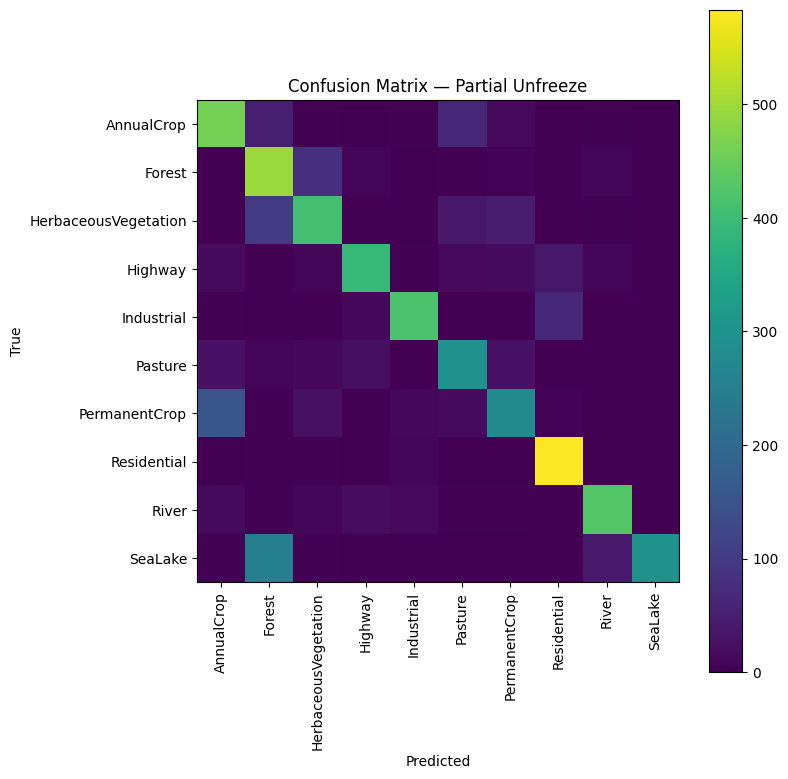

Saved artifacts in: /home/oshri/code/clip-rs-fewshot/results/fewshot/ViT-L-14_k5_seed42


In [39]:
def save_json(obj, path):
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w") as f: json.dump(obj, f, indent=2)

summary = {"config": {
    "backend": "HF Datasets",
    "model_name": MODEL_NAME,
    "pretrained": PRETRAINED,
    "k_shots": K_SHOTS,
    "epochs_probe": EPOCHS_PROBE,
    "epochs_partial": EPOCHS_PARTIAL if DO_PARTIAL_UNFREEZE else 0,
    "seed": SEED,
}}

summary["linear_probe"] = {
    "top1": float(metrics_probe["top1"]),
    "top5": float(metrics_probe["top5"]),
    "confusion_matrix": metrics_probe["cm"],
}

if DO_PARTIAL_UNFREEZE and m_partial is not None:
    summary["partial_unfreeze"] = {
        "top1": float(m_partial["top1"]),
        "top5": float(m_partial["top5"]),
        "confusion_matrix": m_partial["cm"],
    }

save_json(summary, OUTDIR / "week2_fewshot_summary.json")

# Print table
print("\nWeek 2 Results (Val)")
print("Linear Probe     : Top-1 = {:.2f}% | Top-5 = {:.2f}%".format(summary["linear_probe"]["top1"]*100, summary["linear_probe"]["top5"]*100))
if "partial_unfreeze" in summary:
    print("Partial Unfreeze : Top-1 = {:.2f}% | Top-5 = {:.2f}%".format(summary["partial_unfreeze"]["top1"]*100, summary["partial_unfreeze"]["top5"]*100))

# Plot confusion matrix for best method
best_name = "Linear Probe"
best_cm = np.array(summary["linear_probe"]["confusion_matrix"])
if "partial_unfreeze" in summary and summary["partial_unfreeze"]["top1"] >= summary["linear_probe"]["top1"]:
    best_name = "Partial Unfreeze"
    best_cm = np.array(summary["partial_unfreeze"]["confusion_matrix"])

fig = plt.figure(figsize=(8,8))
plt.imshow(best_cm, interpolation='nearest')
plt.title(f"Confusion Matrix — {best_name}")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, [id2label[i] for i in range(num_classes)], rotation=90)
plt.yticks(tick_marks, [id2label[i] for i in range(num_classes)])
plt.tight_layout()
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()
fig.savefig(OUTDIR / f"cm_{best_name.replace(' ','_').lower()}.png", bbox_inches='tight', dpi=200)

# Save training histories
with open(OUTDIR / "hist_linear_probe.json", "w") as f:
    json.dump(probe_hist, f, indent=2)
if partial_hist is not None:
    with open(OUTDIR / "hist_partial_unfreeze.json", "w") as f:
        json.dump(partial_hist, f, indent=2)

print("Saved artifacts in:", OUTDIR.resolve())


## Notes & Expected Ranges

- **Linear probe (k=5)** on EuroSAT usually adds **+5–10 pts** over zero-shot for ViT-B/32; more for ViT-L/14.
- **Partial unfreeze** (last block + head, ~5 epochs) can add another **+2–6 pts** (watch LR ratios).

### Tips
- For bigger gains quickly:
  - Switch to **ViT-L/14**: `MODEL_NAME="ViT-L-14"; PRETRAINED="laion2b_s32b_b82k"`.
  - Use **K_SHOTS = 10**.
- Keep eval preprocessing **clean** (resize/center-crop/normalize).
- Use fixed **seed** and **stratified split** for reproducibility.

## Next (Week 3)
- Systematic prompt ablations & (optional) learnable prompts (CoOp-style).
- Report: zero-shot vs. linear probe vs. partial unfreeze in one table + per-class plots.